In [1]:
%reload_ext autoreload
%autoreload 2

%aimport lhcpiv

In [2]:
import os
import time
import datetime

from lhcpiv import tools, velocity_vectors

from openpiv import tools as tools_piv
from openpiv import preprocess, piv

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score
import cv2

In [168]:
videos = tools.transform_all_videos_to_frames(path="data/videos/", qty_frames=120)

Created folder data/videos/18_5ls_44cm/20220212221639
Success
Created folder data/videos/18_5ls_44cm/20220212221620
Success
Created folder data/videos/18_5ls_44cm/20220212221633
Success
Created folder data/videos/18_5ls_44cm/20220212221627
Success
Created folder data/videos/18_5ls_44cm/20220212221646
Success
Created folder data/videos/9_7ls_27cm/20220212203820
Success
Created folder data/videos/9_7ls_27cm/20220212203801
Success
Created folder data/videos/9_7ls_27cm/20220212203808
Success
Created folder data/videos/9_7ls_27cm/20220212203814
Success
Created folder data/videos/11_6ls_30_5cm/20220212210133
Success
Created folder data/videos/11_6ls_30_5cm/20220212210151
Success
Created folder data/videos/11_6ls_30_5cm/20220212210145
Success
Created folder data/videos/11_6ls_30_5cm/20220212210139
Success
Created folder data/videos/11_6ls_30_5cm/20220212210126
Success
Created folder data/videos/27_3ls_33cm/20220212222912
Success
Created folder data/videos/27_3ls_33cm/20220212222918
Success
Cr

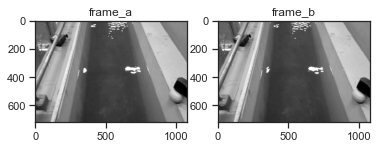

In [169]:
first_frame = 12
frame_a = tools_piv.imread(
    os.path.join(
        "data",
        "videos",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame).zfill(6)}.jpg",
    )
)
frame_b = tools_piv.imread(
    os.path.join(
        "data",
        "videos",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame + 1).zfill(6)}.jpg",
    )
)

plt.subplot(121), plt.imshow(frame_a, cmap=plt.cm.gray), plt.title("frame_a")
plt.subplot(122), plt.imshow(frame_b, cmap=plt.cm.gray), plt.title("frame_b")
plt.show()

In [170]:
pixel_coords = np.loadtxt(
    f"data/pixel_coords/{list(videos.keys())[0]}.txt", delimiter=","
).astype(np.float32)

real_coords = np.float32(
    [
        [400, 250],
        [0, 250],
        [0, 0],
        [400, 0],
    ]
)

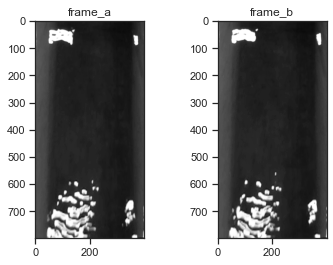

In [171]:
first_frame = 5
frame_a = tools_piv.imread(
    os.path.join(
        "data",
        "videos",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame).zfill(6)}.jpg",
    )
)
frame_b = tools_piv.imread(
    os.path.join(
        "data",
        "videos",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame + 1).zfill(6)}.jpg",
    )
)
M = cv2.getPerspectiveTransform(pixel_coords, real_coords)
frame_a = cv2.warpPerspective(frame_a, M, (400, 800))
frame_b = cv2.warpPerspective(frame_b, M, (400, 800))
plt.subplot(121), plt.imshow(frame_a, cmap=plt.cm.gray), plt.title("frame_a")
plt.subplot(122), plt.imshow(frame_b, cmap=plt.cm.gray), plt.title("frame_b")
plt.show()

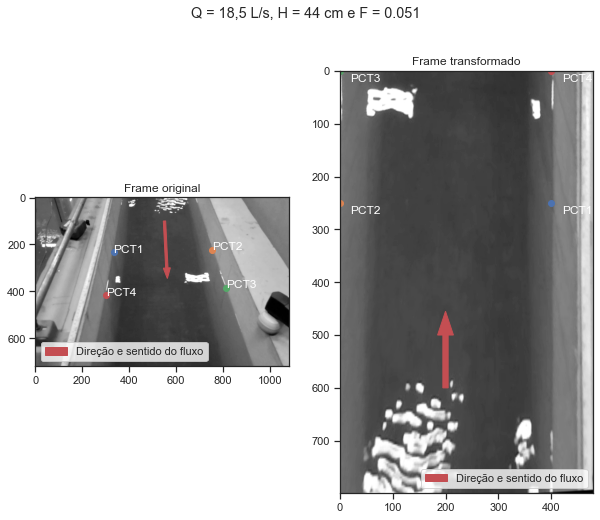

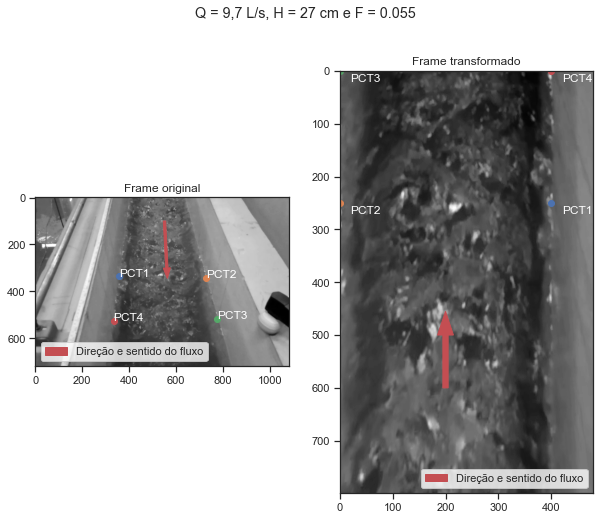

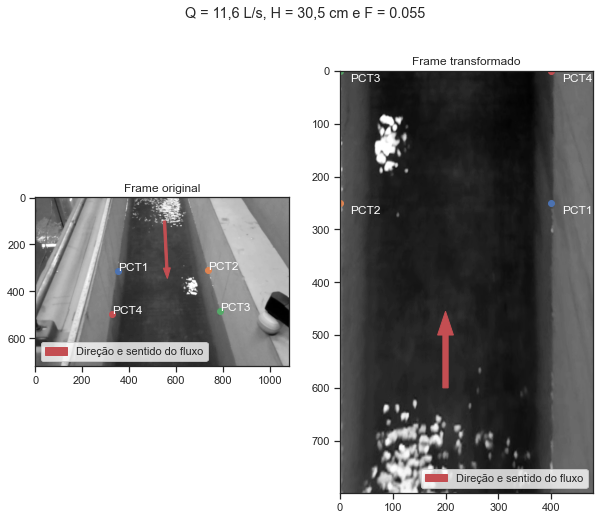

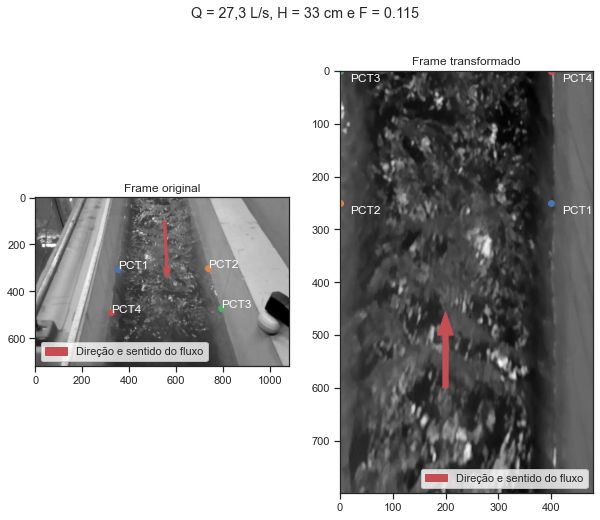

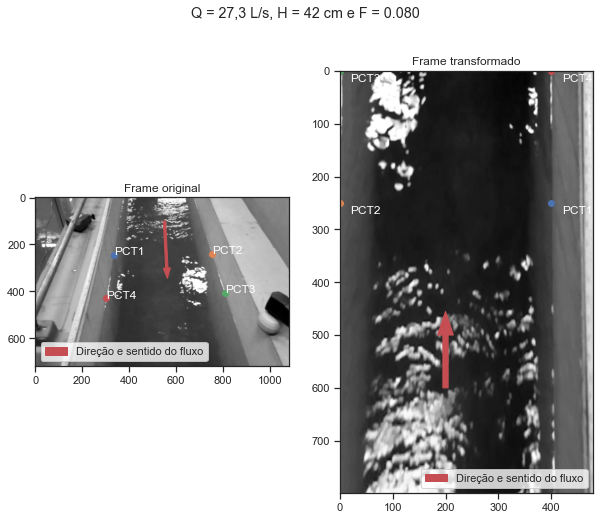

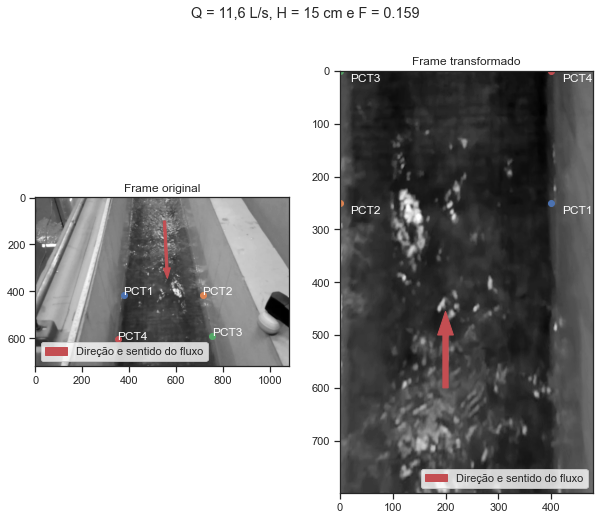

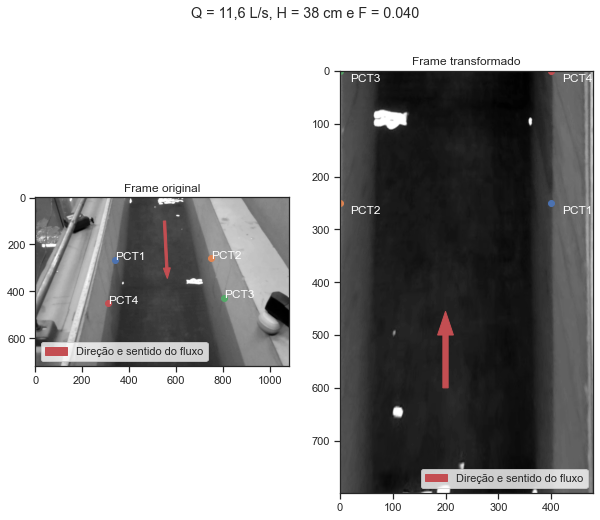

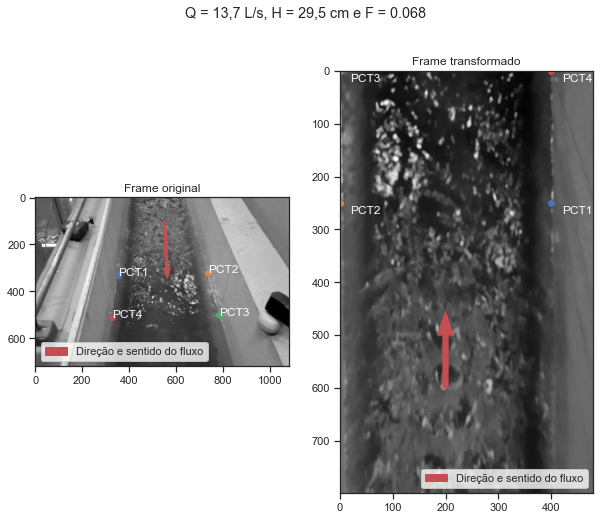

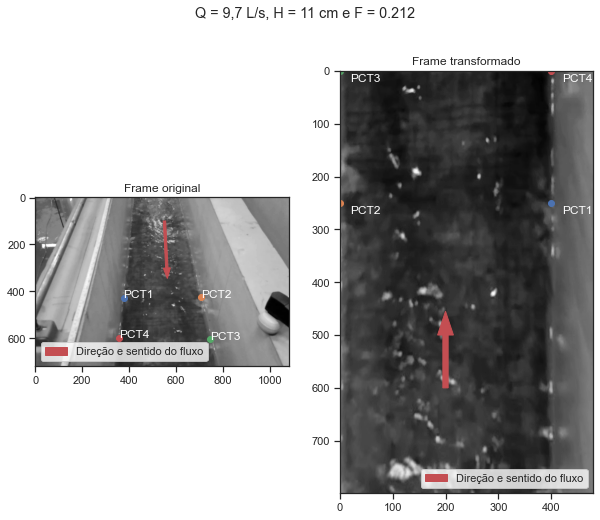

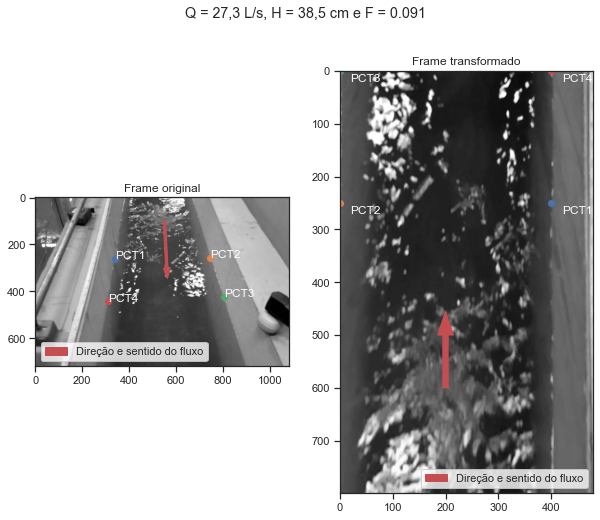

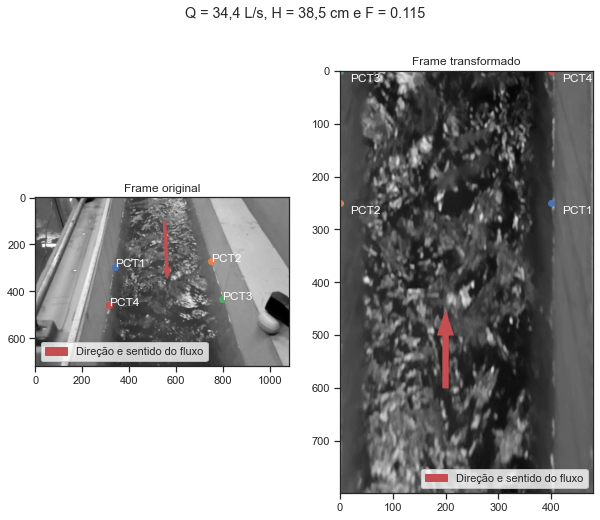

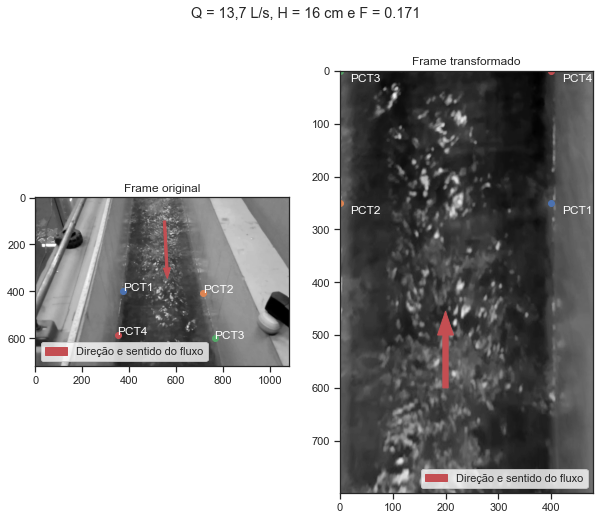

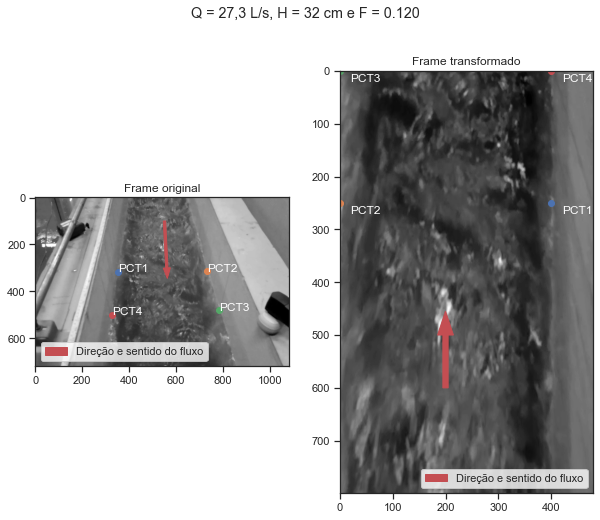

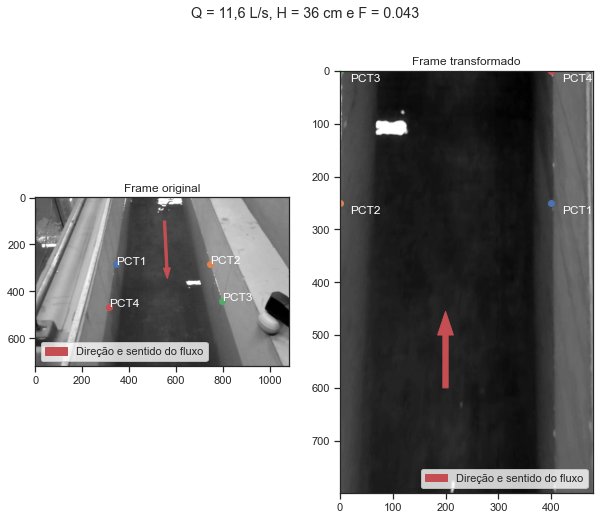

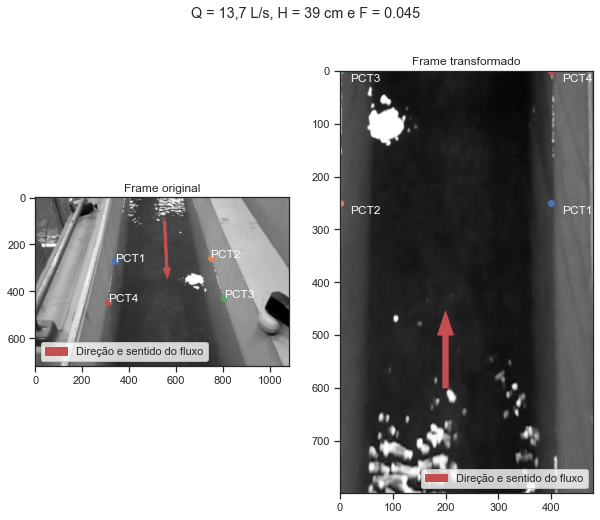

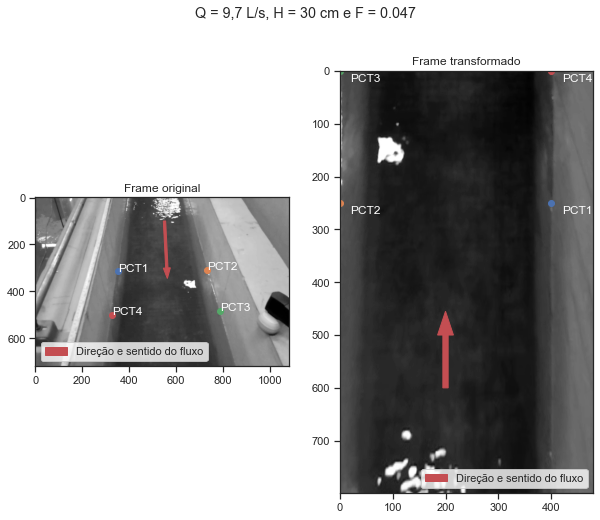

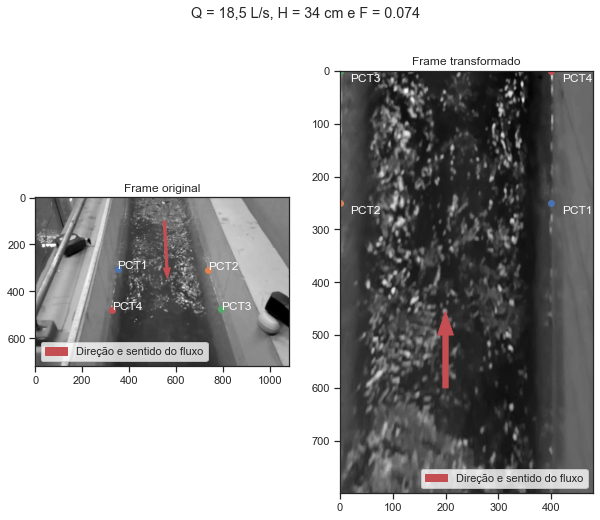

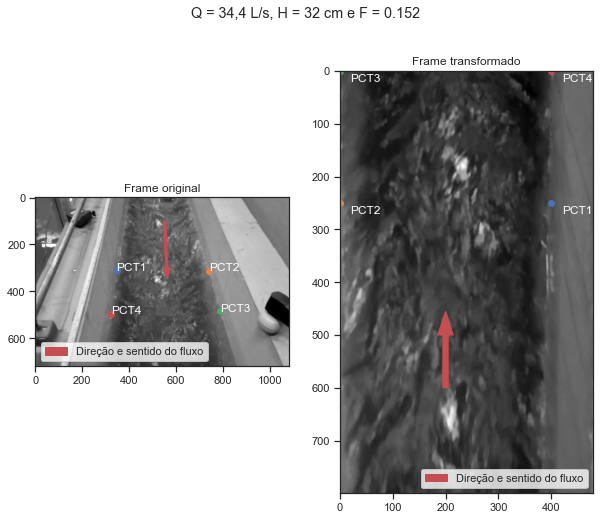

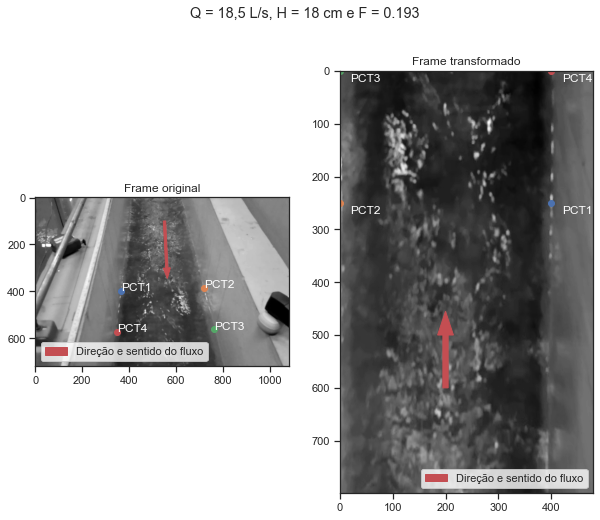

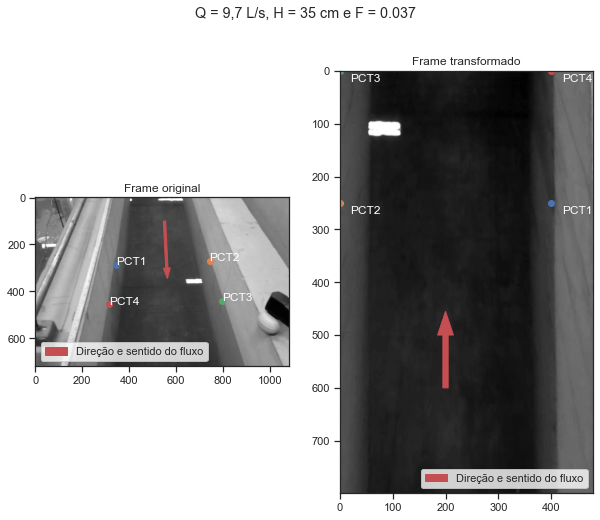

In [166]:
sns.set(style="ticks")

for video in list(videos.keys()):
    pixel_coords = np.loadtxt(f"data/pixel_coords/{video}.txt", delimiter=",").astype(
        np.float32
    )

    vazao = video.split("ls_")[0].replace("_", ",")
    lamina = video.split("ls_")[-1].replace("_", ",").replace("cm", "")
    froude = (
        float(vazao.replace(",", "."))
        / (0.4 * 1000 * float(lamina.replace(",", ".")) / 100)
        / np.sqrt(9.81 * float(lamina.replace(",", ".")) / 100)
    )

    first_frame = 5
    frame_a = tools_piv.imread(
        os.path.join(
            "data",
            "videos",
            video,
            videos[video][0],
            f"frame{str(first_frame).zfill(6)}.jpg",
        )
    )
    M = cv2.getPerspectiveTransform(pixel_coords, real_coords)
    frame_a_transformed = cv2.warpPerspective(frame_a, M, (480, 800))

    # plot
    fig, ax = plt.subplots(ncols=2, figsize=(10, 8))
    fig.suptitle(f"Q = {vazao} L/s, H = {lamina} cm e F = {froude:.3f}")

    ax[0].imshow(frame_a, cmap=plt.cm.gray)
    ax[0].arrow(
        550,
        100,
        10,
        200,
        color="r",
        width=10,
        head_width=30,
        label="Direção e sentido do fluxo",
    )
    for i, pixel in enumerate(pixel_coords):
        ax[0].scatter(pixel[0], pixel[1])
        ax[0].annotate(f"PCT{i + 1}", pixel, color="w")
    ax[0].set_title(f"Frame original")
    ax[0].legend()

    ax[1].imshow(frame_a_transformed, cmap=plt.cm.gray)
    ax[1].arrow(
        200,
        600,
        0,
        -100,
        color="r",
        width=10,
        head_width=30,
        label="Direção e sentido do fluxo",
    )
    for i, pixel in enumerate(real_coords):
        ax[1].scatter(pixel[0], pixel[1])
        ax[1].annotate(f"PCT{i + 1}", pixel + 20, color="w")
    ax[1].legend(loc="lower right")
    ax[1].set_title(f"Frame transformado")
    plt.savefig(os.path.join("results/figures/transformed", f"{video}.png"), dpi=300)
    plt.show()

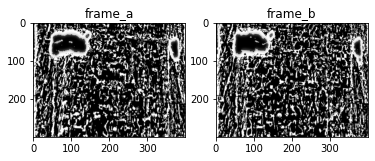

In [18]:
first_frame = 6

mask_params = {"method": "edges", "filter_size": 3, "threshold": 0.01}

frame_a = tools_piv.imread(
    os.path.join(
        "data",
        "videos",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame).zfill(6)}.jpg",
    )
)
frame_b = tools_piv.imread(
    os.path.join(
        "data",
        "videos",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame + 1).zfill(6)}.jpg",
    )
)
M = cv2.getPerspectiveTransform(pixel_coords, real_coords)
frame_a, _ = preprocess.dynamic_masking(frame_a, **mask_params)
frame_b, _ = preprocess.dynamic_masking(frame_b, **mask_params)
frame_a = cv2.warpPerspective(frame_a, M, (400, 300))
frame_b = cv2.warpPerspective(frame_b, M, (400, 300))

plt.subplot(121), plt.imshow(frame_a, cmap=plt.cm.gray), plt.title("frame_a")
plt.subplot(122), plt.imshow(frame_b, cmap=plt.cm.gray), plt.title("frame_b")
plt.show()

In [56]:
# hyperparameters
winsize = 32
searchsize = winsize * 2
overlap = winsize // 2
threshold = 1.04
k = 1
masking = False
masking_method = "edges"
masking_filter_size = 7
masking_threshold = 0.01
masking_params = {
    "method": masking_method,
    "filter_size": masking_filter_size,
    "threshold": masking_threshold,
}

results = {
    "videos_path": [],
    "vazao_real": [],
    "vazao_calculada": [],
    "altura_real": [],
}

for vazao in videos:
    for movie in videos[vazao]:
        pixel_coords = np.loadtxt(
            f"data/pixel_coords/{vazao}.txt", delimiter=","
        ).astype(np.float32)
        real_coords = np.float32(
            [
                [400, 250],
                [0, 250],
                [0, 0],
                [400, 0],
            ]
        )

        preffix_path = "./data/videos/" + vazao + "/" + movie + "/"
        now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        output_path = os.path.join(preffix_path, "piv_results", now)

        frames = [frame for frame in os.listdir(preffix_path) if frame.endswith(".jpg")]
        frames.sort()

        pairs = []

        for j, frame in enumerate(frames):
            if j == len(frames) - 1:
                pass
            else:
                pairs.append((frame, frames[j + 1]))

        for frame_a, frame_b in pairs:
            velocity_vectors.calculate(
                preffix_path,
                frame_a,
                frame_b,
                pixel_coords,
                real_coords,
                roi=(400, 800),
                winsize=winsize,
                searchsize=searchsize,
                overlap=overlap,
                dt=1 / 30,
                threshold=threshold,
                scaling_factor=1000,
                masking=masking,
                masking_params=masking_params,
                verbose=False,
                show_fig=False,
                output_path=output_path,
            )
            time.sleep(0.5)

        df_final = tools.get_all_results(output_path, "median")
        df_final.to_csv(os.path.join(output_path, "final.csv"), index=False)

        real_flow = float(preffix_path.split("/")[-3].split("ls_")[0].replace("_", "."))
        real_height = float(
            preffix_path.split("/")[-3]
            .split("ls_")[-1]
            .replace("_", ".")
            .replace("cm", "")
        )

        df_final = df_final[(df_final["y"] >= 0.5) & (df_final["y"] <= 0.7)]
        flow = df_final["v"].mean() * 0.4 * (real_height / 100) * 1000 * k

        results["videos_path"].append("_".join(preffix_path.split("/")[-3:-1]))
        results["vazao_real"].append(real_flow)
        results["vazao_calculada"].append(flow)
        results["altura_real"].append(real_height)

rmse = np.sqrt(mean_squared_error(results["vazao_real"], results["vazao_calculada"]))
r_quadrado = r2_score(results["vazao_real"], results["vazao_calculada"])

print(f"RMSE: {rmse:.2f}; r2: {r_quadrado: .2f}")

Folder ./data/videos/18_5ls_44cm/20220212221639/piv_results/20220723211959 doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221620/piv_results/20220723212107 doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221633/piv_results/20220723212215 doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221627/piv_results/20220723212323 doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221646/piv_results/20220723212431 doesn't exists... creating...
Folder ./data/videos/9_7ls_27cm/20220212203820/piv_results/20220723212538 doesn't exists... creating...
Folder ./data/videos/9_7ls_27cm/20220212203801/piv_results/20220723212645 doesn't exists... creating...
Folder ./data/videos/9_7ls_27cm/20220212203808/piv_results/20220723212752 doesn't exists... creating...
Folder ./data/videos/9_7ls_27cm/20220212203814/piv_results/20220723212859 doesn't exists... creating...
Folder ./data/videos/11_6ls_30_5cm/20220212210133/piv_resul

In [57]:
results

{'videos_path': ['18_5ls_44cm_20220212221639',
  '18_5ls_44cm_20220212221620',
  '18_5ls_44cm_20220212221633',
  '18_5ls_44cm_20220212221627',
  '18_5ls_44cm_20220212221646',
  '9_7ls_27cm_20220212203820',
  '9_7ls_27cm_20220212203801',
  '9_7ls_27cm_20220212203808',
  '9_7ls_27cm_20220212203814',
  '11_6ls_30_5cm_20220212210133',
  '11_6ls_30_5cm_20220212210151',
  '11_6ls_30_5cm_20220212210145',
  '11_6ls_30_5cm_20220212210139',
  '11_6ls_30_5cm_20220212210126',
  '27_3ls_33cm_20220212222912',
  '27_3ls_33cm_20220212222918',
  '27_3ls_33cm_20220212222930',
  '27_3ls_33cm_20220212222936',
  '27_3ls_33cm_20220212222924',
  '27_3ls_42cm_20220212225005',
  '27_3ls_42cm_20220212224959',
  '27_3ls_42cm_20220212224953',
  '27_3ls_42cm_20220212224935',
  '27_3ls_42cm_20220212224943',
  '11_6ls_15cm_20220212205207',
  '11_6ls_15cm_20220212205220',
  '11_6ls_15cm_20220212205200',
  '11_6ls_15cm_20220212205226',
  '11_6ls_15cm_20220212205213',
  '11_6ls_38cm_20220212210957',
  '11_6ls_38cm_2022

In [58]:
df_results = pd.DataFrame(results)
df_results["vazao_calculada"] = df_results["vazao_calculada"] * -1
df_results["erro"] = df_results["vazao_real"] - df_results["vazao_calculada"]
df_results["erro_quadratico"] = df_results["erro"] ** 2
df_results["froude"] = (
    df_results["vazao_real"] / (0.4 * df_results["altura_real"] * 0.01 * 1000)
) / np.sqrt(9.81 * 0.01 * df_results["altura_real"])
df_results[df_results["froude"] > 0.1]

,videos_path,vazao_real,vazao_calculada,altura_real,erro,erro_quadratico,froude
14,27_3ls_33cm_20220212222912,27.3,-3.801188,33.0,31.101188,967.283864,0.114947
15,27_3ls_33cm_20220212222918,27.3,-5.987850,33.0,33.287850,1108.080958,0.114947
16,27_3ls_33cm_20220212222930,27.3,-6.706425,33.0,34.006425,1156.436941,0.114947
17,27_3ls_33cm_20220212222936,27.3,-4.743956,33.0,32.043956,1026.815132,0.114947
18,27_3ls_33cm_20220212222924,27.3,-5.150888,33.0,32.450888,1053.060100,0.114947
24,11_6ls_15cm_20220212205207,11.6,0.754312,15.0,10.845688,117.628937,0.159377
25,11_6ls_15cm_20220212205220,11.6,1.304156,15.0,10.295844,106.004399,0.159377
26,11_6ls_15cm_20220212205200,11.6,1.062188,15.0,10.537812,111.045492,0.159377
27,11_6ls_15cm_20220212205226,11.6,-2.872687,15.0,14.472687,209.458683,0.159377
28,11_6ls_15cm_20220212205213,11.6,-0.950063,15.0,12.550062,157.504069,0.159377


In [59]:
rmse = np.sqrt(
    df_results["erro_quadratico"].sum() / df_results["erro_quadratico"].count()
)
rmse

21.965894266199214

In [162]:
preffix_path = "./data/videos/18_5ls_34cm/"
preffix_path = os.path.join(
    preffix_path, os.listdir(preffix_path)[0].split(".")[0], "piv_results"
)
preffix_path = os.path.join(preffix_path, os.listdir(preffix_path)[-1])
print(preffix_path)
df_test = pd.read_csv(preffix_path + "/final.csv")

./data/videos/18_5ls_34cm/20220212221012/piv_results/20220718235217


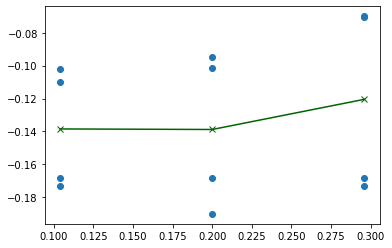

ValueError: could not convert string to float: 'piv.results'

In [163]:
df_plot = (
    df_test.copy()[(df_test["y"] >= 0.6) & (df_test["y"] <= 1)]
    # [df_test['v'] < 0]
    # .groupby('x')['v'].mean().reset_index()
)

v_mean = df_plot.groupby("x")["v"].agg("mean").reset_index()
plt.scatter(x=df_plot["x"], y=df_plot["v"])
plt.plot(v_mean["x"], v_mean["v"], marker="x", color="darkgreen")
plt.show()

real_flow = float(preffix_path.split("/")[-2].split("ls")[0].replace("_", "."))
real_height = float(
    preffix_path.split("/")[-2]
    .split("ls")[-1]
    .split("_")[-1]
    .split("_")[-1]
    .replace("_", ".")
    .replace("cm", "")
)

flow = (-1) * df_plot["v"].mean() * 0.4 * (real_height / 100) * 1000 * 0.85

print(f"Vazão medida: {real_flow}")
print(f"Vazão calculada: {flow}")

# Função

In [177]:
def get_results(
    winsize,
    threshold,
    k=0.85,
    masking=False,
    masking_method="edges",
    masking_filter_size=7,
    masking_threshold=0.01,
):
    # hyperparameters
    searchsize = winsize * 2
    overlap = winsize // 2
    masking_params = {
        "method": masking_method,
        "filter_size": masking_filter_size,
        "threshold": masking_threshold,
    }

    results = {
        "videos_path": [],
        "vazao_real": [],
        "vazao_calculada": [],
        "altura_real": [],
    }

    for vazao in videos:
        for movie in videos[vazao]:
            pixel_coords = np.loadtxt(
                f"data/pixel_coords/{vazao}.txt", delimiter=","
            ).astype(np.float32)
            real_coords = np.float32(
                [
                    [400, 250],
                    [0, 250],
                    [0, 0],
                    [400, 0],
                ]
            )

            preffix_path = "./data/videos/" + vazao + "/" + movie + "/"
            now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
            output_path = os.path.join(preffix_path, "piv_results", now)

            frames = [
                frame for frame in os.listdir(preffix_path) if frame.endswith(".jpg")
            ]
            frames.sort()

            pairs = []

            for j, frame in enumerate(frames):
                if j == len(frames) - 1:
                    pass
                else:
                    pairs.append((frame, frames[j + 1]))

            for frame_a, frame_b in pairs:
                velocity_vectors.calculate(
                    preffix_path,
                    frame_a,
                    frame_b,
                    pixel_coords,
                    real_coords,
                    roi=(400, 800),
                    winsize=winsize,
                    searchsize=searchsize,
                    overlap=overlap,
                    dt=1 / 30,
                    threshold=threshold,
                    scaling_factor=1000,
                    masking=masking,
                    masking_params=masking_params,
                    verbose=False,
                    show_fig=False,
                    output_path=output_path,
                )
                time.sleep(0.5)

            df_final = tools.get_all_results(output_path, "median")
            df_final.to_csv(os.path.join(output_path, "final.csv"), index=False)

            real_flow = float(
                preffix_path.split("/")[-3].split("ls_")[0].replace("_", ".")
            )
            real_height = float(
                preffix_path.split("/")[-3]
                .split("ls_")[-1]
                .replace("_", ".")
                .replace("cm", "")
            )

            df_final = df_final[(df_final["y"] >= 0.5) & (df_final["y"] <= 0.7)]
            flow = df_final["v"].mean() * 0.4 * (real_height / 100) * 1000 * k

            results["videos_path"].append("_".join(preffix_path.split("/")[-3:-1]))
            results["vazao_real"].append(real_flow)
            results["vazao_calculada"].append(flow)
            results["altura_real"].append(real_height)

    rmse = np.sqrt(
        mean_squared_error(results["vazao_real"], results["vazao_calculada"])
    )

    print(f"RMSE: {rmse:.2f}")

    return results, rmse

Hyperparametrization

In [175]:
from itertools import product


def grid_parameters(parameters):
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))


# hyperparameters
parameters = {
    "winsize": [20, 30, 40, 50, 60, 80],
    "threshold": [1, 1.01, 1.02, 1.03, 1.04, 1.05, 1.1],
}

In [ ]:
grid_search = []
for settings in grid_parameters(parameters):
    print(f"Parâmetros: {settings}")
    _, rmse = get_results(**settings)
    settings["RMSE"] = rmse
    grid_search.append(settings)

Parâmetros: {'winsize': 20, 'threshold': 1}
Folder ./data/videos/18_5ls_44cm/20220212221639/transformed/ doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221639/piv_results doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221639/piv_results/20220724164049 doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221620/transformed/ doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221620/piv_results doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221620/piv_results/20220724164156 doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221633/transformed/ doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221633/piv_results doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221633/piv_results/20220724164304 doesn't exists... creating...
Folder ./data/videos/18_5ls_44cm/20220212221627/transformed/ doesn't exists... creating...
Folder 

In [20]:
grid_search

[{'winsize': 20,
  'threshold': 1,
  'k': 0.7,
  'RMSE': 14.884671197542003,
  'r2_score': -5.169113699432053},
 {'winsize': 20,
  'threshold': 1,
  'k': 0.7999999999999999,
  'RMSE': 14.435797358181839,
  'r2_score': -4.802642807680241},
 {'winsize': 20,
  'threshold': 1,
  'k': 0.8999999999999999,
  'RMSE': 14.184089888773714,
  'r2_score': -4.60205325708593},
 {'winsize': 20,
  'threshold': 1,
  'k': 0.9999999999999999,
  'RMSE': 14.315550424271345,
  'r2_score': -4.706376014939358},
 {'winsize': 20,
  'threshold': 1,
  'k': 1.0999999999999999,
  'RMSE': 14.311678997658829,
  'r2_score': -4.703290024095845},
 {'winsize': 20,
  'threshold': 1.01,
  'k': 0.7,
  'RMSE': 14.61638677931544,
  'r2_score': -4.948731088246161},
 {'winsize': 20,
  'threshold': 1.01,
  'k': 0.7999999999999999,
  'RMSE': 14.37548291798156,
  'r2_score': -4.754255869459243},
 {'winsize': 20,
  'threshold': 1.01,
  'k': 0.8999999999999999,
  'RMSE': 14.38675614602636,
  'r2_score': -4.763284362499366},
 {'winsiz

In [21]:
grid_search_parameters = pd.DataFrame(grid_search)

In [26]:
grid_search_parameters.sort_values("RMSE", ascending=True).to_csv(
    "grid_search_parameters.csv"
)

In [25]:
grid_search_parameters

,winsize,threshold,k,RMSE,r2_score
64,30,1.05,1.1,12.444349,-3.312098
54,30,1.03,1.1,12.668834,-3.469074
39,30,1.00,1.1,12.809204,-3.568657
63,30,1.05,1.0,12.835559,-3.587477
43,30,1.01,1.0,12.857992,-3.603526
...,...,...,...,...,...
158,60,1.03,1.0,99.746746,-276.039538
168,60,1.05,1.0,100.169080,-278.390512
159,60,1.03,1.1,103.571101,-297.690542
164,60,1.04,1.1,108.910467,-329.280949


In [203]:
videos_dir = os.listdir("data/videos")

In [209]:
for dir in videos_dir:
    height = float(dir.split("ls_")[-1].split("cm")[0].replace("_", "."))
    with open(f"data/heights/{dir}.txt", "w") as f:
        f.write(f"0,{height}\n")
        f.write(f"20,{height}\n")
        f.write(f"40,{height}\n")